Tensorflow & venv(tfod) folder: https://drive.google.com/file/d/1bazCHfp4HThlfODR_09-IJkw1Wsz982A/view?usp=sharing

In [5]:
import os
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import cv2 
from glob import glob
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [6]:
CUSTOM_MODEL_NAME = 'AP(ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8)' 
LABEL_MAP_NAME = 'label_map.pbtxt'

In [7]:
paths = {
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images','spine_dataset','AP'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
}
files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [8]:
AP_labels = [{'name':'APL1', 'id':1}, {'name':'APL2', 'id':2},{'name':'APL3', 'id':3},{'name':'APL4', 'id':4},{'name':'APL5', 'id':5}]
LA_labels = [{'name':'LAL1', 'id':1}, {'name':'LAL2', 'id':2},{'name':'LAL3', 'id':3},{'name':'LAL4', 'id':4},{'name':'LAL5', 'id':5}]
labels = AP_labels

In [9]:
# # Load pipeline config and build a detection model
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])
category_index
labelmap_N = category_index
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)


# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-13')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections


def getindex(detectionclasses,label):
    Lindex  = ""
    j=0
    for i in detectionclasses:
        if labelmap_N[i+1]['name'] == label:
            Lindex = j
            break
        j = j + 1
    return Lindex


In [10]:
def detect_Lumbar(img, lumbar=""):
    lumbar_map = {"L1":1,"L2":2,"L3":3,"L4":4,"L5":5}
    image_np = np.array(img)
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    plt.figure(figsize = (20,20))
    if (lumbar==""):
        viz_utils.visualize_boxes_and_labels_on_image_array(
                    image_np_with_detections,
                    detections['detection_boxes'],
                    detections['detection_classes']+label_id_offset,
                    detections['detection_scores'],
                    category_index,
                    use_normalized_coordinates=True,
                    max_boxes_to_draw=5,
                    min_score_thresh=.5,
                    agnostic_mode=False)

        plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
    else:
        box_index =np.where(detections['detection_classes']+label_id_offset == lumbar_map[lumbar])[0][0]
        detected_box = detections['detection_boxes'][box_index]
        image_np_with_detection = image_np.copy()
        viz_utils.visualize_boxes_and_labels_on_image_array(
                    image_np_with_detection,
                    np.array([detections['detection_boxes'][box_index]]),
                    np.array([detections['detection_classes'][box_index]])+label_id_offset,
                    np.array([detections['detection_scores'][box_index]]),
                    category_index,
                    use_normalized_coordinates=True,
                    max_boxes_to_draw=5,
                    min_score_thresh=.5,
                    agnostic_mode=False)
        plt.imshow(cv2.cvtColor(image_np_with_detection, cv2.COLOR_BGR2RGB))
    return detections

0001-F-037Y0


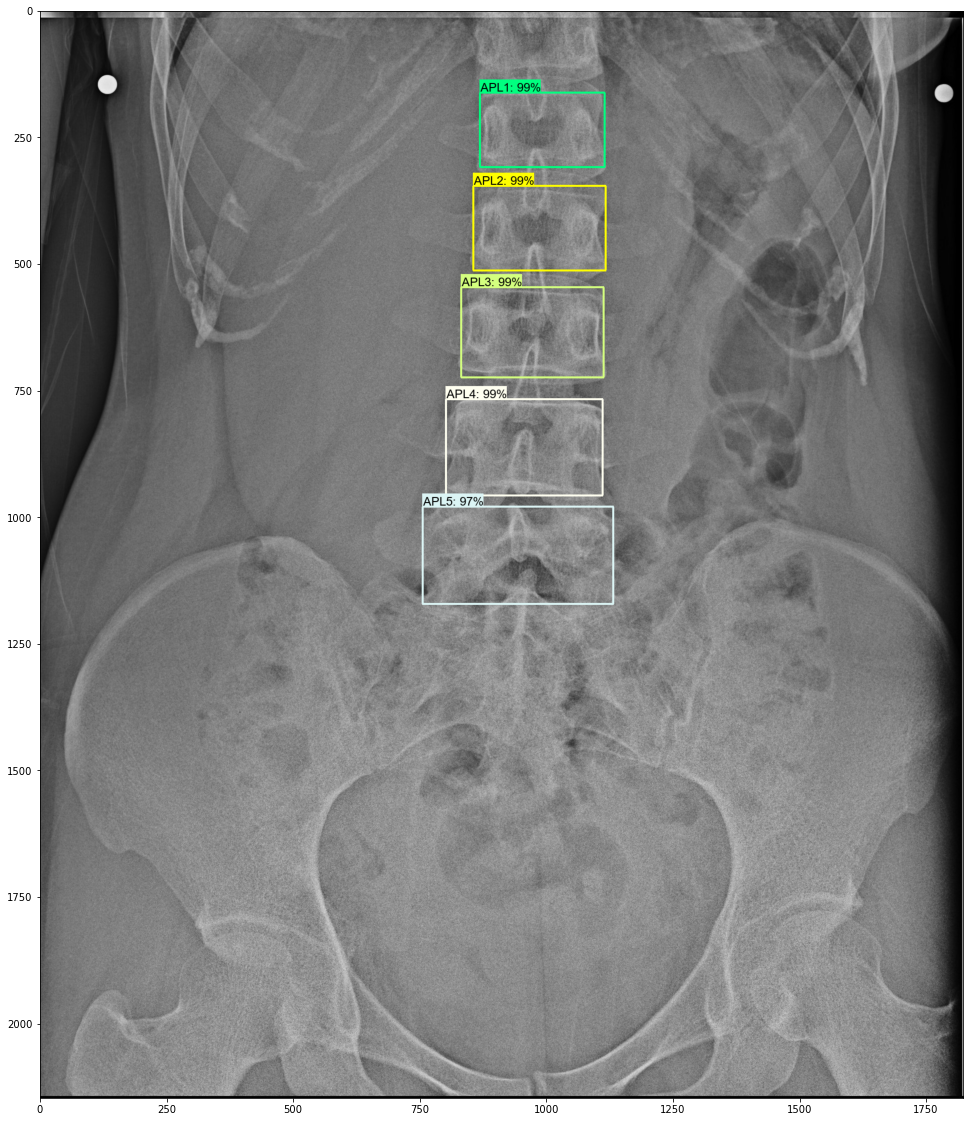

In [12]:

Image_Path = os.path.join(paths['IMAGE_PATH'])
Image_Path
for i in (glob(Image_Path + '\\*.jpg')):
    dot = i.find(".jpg")
    filename = i[dot-12:dot]
    # if(filename!='0159-M-062Y0'):
    #     continue
    print(filename)
    img = cv2.imread(i)
    result = detect_Lumbar(img) 
    
    break
    
    